# Classification with Python

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-05-17 10:37:22--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.02s   

2020-05-17 10:37:23 (1.08 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



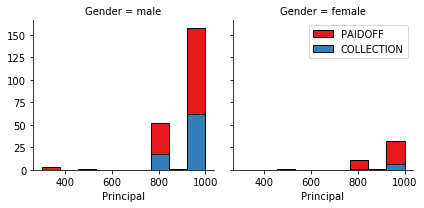

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

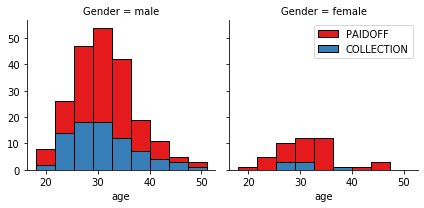

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

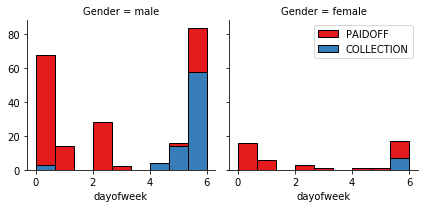

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
# Dict for storing all final models
models = dict()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [22]:
print ('Starting Data Set:', X.shape,  y.shape)

Starting Data Set: (346, 8) (346,)


In [23]:
#Split Data 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=4)
#Data check
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (259, 8) (259,)
Test set: (87, 8) (87,)


In [24]:
# Search best K
# It is advisible to take odd values for binary classification to avoid the ties
# i.e. two classes labels achieving the same score.
k_range = list(range(1,31))[::2]  # Only odd K values are used!
Ks = 11
mean_acc = []
best_score = 0
for k in k_range:
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    score = metrics.accuracy_score(y_test, yhat)
    # score = metrics.jaccard_similarity_score(y_test, yhat)
    mean_acc.append(score)

    # Select and store best parameters
    if score > best_score:
        best_score = score
        best_neigh = neigh
        bestK = k
    
print("\nThe best accuracy is", best_score, "with k =", bestK)


The best accuracy is 0.7931034482758621 with k = 5


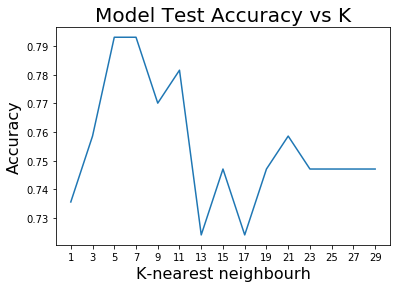

In [25]:
plt.plot(k_range,mean_acc)
plt.title('Model Test Accuracy vs K', fontsize=20)
plt.xticks(k_range)
plt.xlabel('K-nearest neighbourh', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

In [26]:
# Train Model and Predict with best K using ALL dataset - X
neigh = KNeighborsClassifier(n_neighbors = bestK).fit(X,y)
models['KNN']=neigh
print('Model saved')

Model saved


---

# Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier

Text(0.5, 0, 'Max Depth of the Tree')

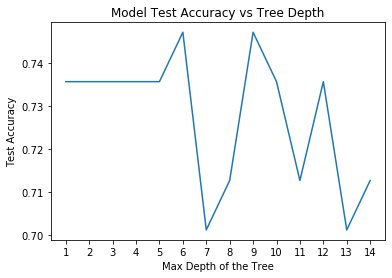

In [28]:
# Search best Tree Depth
tree_depths = list(range(1, 15))
tree_scores = []

for i in tree_depths:
    #Train Model and Predict using previously splited data 
    dtree = DecisionTreeClassifier(criterion="entropy", max_depth = i)
    dtree.fit(X_train,y_train)
    yhat_dt = dtree.predict(X_test)
    
    #Test accuracy score
    dtree_score=metrics.accuracy_score(y_test, yhat_dt)
    tree_scores.append(dtree_score)

plt.plot(tree_depths, tree_scores)
plt.title('Model Test Accuracy vs Tree Depth')
plt.xticks(tree_depths)
plt.ylabel('Test Accuracy')
plt.xlabel('Max Depth of the Tree')

In [29]:
# Train Model and Predict with best depth using ALL dataset - X
dtree = DecisionTreeClassifier(criterion="entropy", max_depth = 6).fit(X,y)
models['DTree']=dtree
print('Model saved')

Model saved


---

# Support Vector Machine

In [30]:
from sklearn import svm

In [31]:
# serach for best regularization paramter C: from 0.001 to 10.0, every 50th 
# 0.001, 0.05, 0.1, 0.15, 0.2  and so on
reg_range = [0.001 * i for i in range(1,10001)][::50]
kernels = ['linear', 'poly', 'rbf']
results = dict()

for k in kernels:
    results[k] = []
    for r in reg_range:
        clf = svm.SVC(C=r, kernel=k, gamma='auto').fit(X_train, y_train)
        yhat_svm = clf.predict(X_test)
        score = metrics.accuracy_score(y_test, yhat_svm)
        results[k].append(score)

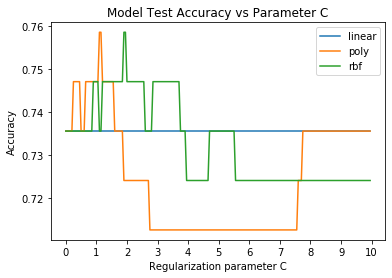

In [32]:
for k, acc in results.items():
    plt.plot(reg_range, acc, label=k)
    
plt.title('Model Test Accuracy vs Parameter C')
plt.xticks(list(range(11)))
plt.ylabel('Accuracy')
plt.xlabel('Regularization parameter C')
plt.legend()   

In [33]:
# Refine and narrow the tuning parameters
# 'Poly' and 'RBF' kernels, C around the number 1.5

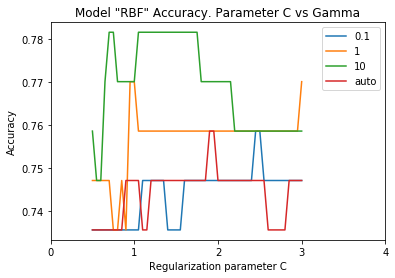

In [34]:
# Tune SVC "RBF" model. 'C' and 'gamma' range
reg_range = [0.001 * i for i in range(500,3001)][::50]
results_rbf = dict()
gammas = [0.1, 1, 10, 'auto']
for g in gammas:
    results_rbf[g] = []
    for r in reg_range:
        clf = svm.SVC(C=r, kernel='rbf', gamma=g).fit(X_train, y_train)
        yhat_svm = clf.predict(X_test)
        score = metrics.accuracy_score(y_test, yhat_svm)
        results_rbf[g].append(score)

for g, acc in results_rbf.items():
    plt.plot(reg_range, acc, label=g)
    
plt.title('Model "RBF" Accuracy. Parameter C vs Gamma')
plt.xticks(list(range(5)))
plt.ylabel('Accuracy')
plt.xlabel('Regularization parameter C')
plt.legend() 

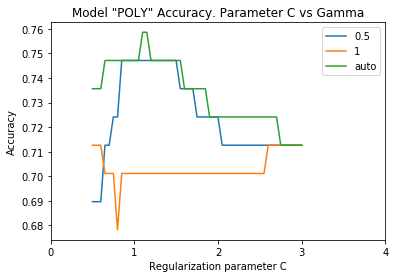

In [35]:
# Tune SVC "Poly" model. 'C' and 'gamma' range
reg_range = [0.001 * i for i in range(500,3001)][::50]
results_poly = dict()
gammas = [0.5, 1, 'auto']
for g in gammas:
    results_poly[g] = []
    for r in reg_range:
        clf = svm.SVC(C=r, kernel='poly', gamma=g).fit(X_train, y_train)
        yhat_svm = clf.predict(X_test)
        score = metrics.accuracy_score(y_test, yhat_svm)
        results_poly[g].append(score)

for g, acc in results_poly.items():
    plt.plot(reg_range, acc, label=g)
    
plt.title('Model "POLY" Accuracy. Parameter C vs Gamma')
plt.xticks(list(range(5)))
plt.ylabel('Accuracy')
plt.xlabel('Regularization parameter C')
plt.legend() 

In [36]:
max_score , max_gama = 0, 0
for i, j in enumerate(results_rbf):
    max_score_in = max(results_rbf[j])
    if max_score_in > max_score:
        max_score = max_score_in
        max_gama = j
    print(max_score_in)

print(f"Max Accuracy: {max_score, max_gama}")

0.7586206896551724
0.7701149425287356
0.7816091954022989
0.7586206896551724
Max Accuracy: (0.7816091954022989, 10)


0.7816091954022989 0.7


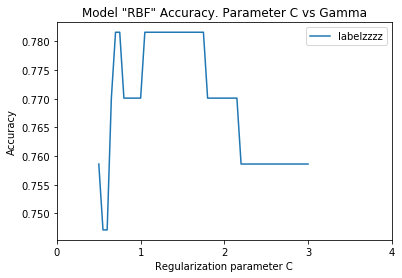

In [37]:
# Last Tune SVC "RBF" model. 
reg_range = [0.001 * i for i in range(500,3001)][::50]
results_rbf = []
max_score , max_C = 0, 0
for r in reg_range:
    clf = svm.SVC(C=r, kernel='rbf', gamma=10).fit(X_train, y_train)
    yhat_svm = clf.predict(X_test)
    max_score_in = metrics.accuracy_score(y_test, yhat_svm)
    if max_score_in > max_score:
        max_score = max_score_in
        max_C = r
    results_rbf.append(max_score_in)

#for g, acc in results_rbf.items():
plt.plot(reg_range, results_rbf, label='labelzzzz')
    
plt.title('Model "RBF" Accuracy. Parameter C vs Gamma')
plt.xticks(list(range(5)))
plt.ylabel('Accuracy')
plt.xlabel('Regularization parameter C')
plt.legend() 
print(max_score, round(max_C,3))

In [38]:
print(f"Max Accuracy on is {max_score},")
print(f"with kernel = RBF, Gamma = 10 and Regularization parameter C = {round(max_C,3)}")

Max Accuracy on is 0.7816091954022989,
with kernel = RBF, Gamma = 10 and Regularization parameter C = 0.7


In [39]:
# Train Model and Predict using ALL dataset - X
svm_model = svm.SVC(C=round(max_C,3), kernel='rbf', gamma=10).fit(X, y)
models['SVC']=svm_model
print('Model saved')

Model saved


---

# Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
# Testing 'lbfgs' solver with different C
results_lbfgs = []
results = dict()
reg_range = [0.001 * i for i in range(1,1001)][::10]
for r in reg_range:
    lr_model = LogisticRegression(C=r, solver='lbfgs').fit(X_train, y_train)
    y_hat_lr = lr_model.predict(X_test)
    score = metrics.accuracy_score(y_test, y_hat_lr)
    results_lbfgs.append(score)


In [42]:
# Testing 'liblinear' solver with different C
results_libl = []
results = dict()
reg_range = [0.001 * i for i in range(1,1001)][::10]
for r in reg_range:
    lr_model = LogisticRegression(C=r, solver='liblinear').fit(X_train, y_train)
    y_hat_lr = lr_model.predict(X_test)
    score = metrics.accuracy_score(y_test, y_hat_lr)
    results_libl.append(score)

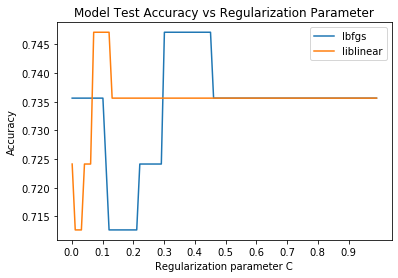

In [43]:
plt.plot(reg_range, results_lbfgs, label='lbfgs')
plt.plot(reg_range, results_libl, label='liblinear')

plt.title('Model Test Accuracy vs Regularization Parameter')

tikz = [ round(elem, 2) for elem in reg_range[0::10] ]
plt.xticks(list(tikz))
plt.ylabel('Accuracy')
plt.xlabel('Regularization parameter C')
plt.legend()    

In [44]:
print(f"Max Accuracy on is {max(results_libl)},")
#poly_reg = [reg_range[i] for i, m in enumerate(results_libl) if m == poly_max]
libl_reg = [reg_range[i] for i, m in enumerate(results_libl) if m == max(results_libl)]
print(f"with 'liblinear' solver and Regularization parameter C = {round(max_C,3)}")

Max Accuracy on is 0.7471264367816092,
with 'liblinear' solver and Regularization parameter C = 0.7


In [45]:
# Train Model and Predict using ALL dataset - X
lr_model = LogisticRegression(C=r, solver='liblinear').fit(X, y)
models['LogR']=lr_model
print('Model saved')

Model saved


# Model Evaluation using Test set

In [46]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [47]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-05-17 10:38:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-05-17 10:38:01 (9.76 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [48]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [49]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['loan_status'].value_counts()
df['dayofweek'] = df['effective_date'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

#df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

df.groupby(['education'])['loan_status'].value_counts(normalize=True)
df[['Principal','terms','age','Gender','education']].head()

Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [50]:
testX = Feature
testY = df['loan_status'].values

# Normalize Data
testX = preprocessing.StandardScaler().fit(testX).transform(testX)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """


In [51]:
# Verify data 
testX[:6]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769,  0.8391575 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [52]:
# Verify data 
testY[:6]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [53]:
model_evals = list()

In [58]:
#KNN
predict_neigh = models['KNN'].predict(testX)
jcsc1=jaccard_similarity_score(testY, predict_neigh)
f1s1=f1_score(testY, predict_neigh, average='weighted')
print(jcsc1)
print(f1s1)
model_evals.append(['KNN', jcsc1, f1s1, 'NA'])

0.815028901734104
0.8005343675294014


In [59]:
#Decision Tree
predict_dtree = models['DTree'].predict(testX)
jcsc2=jaccard_similarity_score(testY, predict_dtree)
f1s2=f1_score(testY, predict_dtree, average='weighted')
print(jcsc2)
print(f1s2)
model_evals.append(['Decision Tree', jcsc2, f1s2, 'NA'])

0.7832369942196532
0.7376924783399335


In [60]:
#SVM
predict_svm = models['SVC'].predict(testX) # svmpoly as reserv svmrbf
jcsc3=jaccard_similarity_score(testY, predict_svm)
f1s3=f1_score(testY, predict_svm, average='weighted') # labels=np.unique(predict_svm)
print(jcsc3)
print(f1s3)
model_evals.append(['SVM', jcsc3, f1s3, 'NA'])

0.7947976878612717
0.7491855071770108


In [62]:
#Logistic Regression
predict_logr = models['LogR'].predict(testX)
jcsc4=jaccard_similarity_score(testY, predict_logr)
f1s4=f1_score(testY, predict_logr, average='weighted')

logr_proba = models['LogR'].predict_proba(testX)
ll4=log_loss(testY,logr_proba)

print(jcsc4)
print(f1s4)
print(ll4)
model_evals.append(['Logistic Regression', jcsc4, f1s4, ll4])

0.7543352601156069
0.6997291283105058
0.4339586486606932


### Building Report DF 

In [63]:
scores_data = {'Jaccard':[jcsc1, jcsc2, jcsc3, jcsc4], 
               'F1-score':[f1s1, f1s2, f1s3, f1s4], 
               'LogLoss':['NA','NA','NA', ll4]} 
result_df = pd.DataFrame(scores_data, index =['KNN', 'Decision Tree', 'SVM', 'LogisticRegression']) 

In [64]:
#report = pd.DataFrame(data=model_evals, columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss'])
#report.set_index('Algorithm', inplace=True)
#report

# Report

In [65]:
result_df

,Jaccard,F1-score,LogLoss
KNN,0.815029,0.800534,NA
Decision Tree,0.783237,0.737692,NA
SVM,0.794798,0.749186,NA
LogisticRegression,0.754335,0.699729,0.433959
